<a href="https://colab.research.google.com/github/dfridland/PyTorch/blob/HW7/HWPyTorch7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls -lha kaggle.json


ls: cannot access 'kaggle.json': No such file or directory


In [2]:
!pip install -q kaggle


In [3]:
 from google.colab import files

In [4]:
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dianafridlyand","key":"eb50b0058efb905468066fe811db57cd"}'}

In [5]:
!mkdir -p ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets list

ref                                                               title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                             Spotify and Youtube                                 9MB  2023-03-20 15:43:25           7220        270  1.0              
ppb00x/country-gdp                                                Country_GDP                                         7KB  2023-04-07 06:47:36            768         27  1.0              
erdemtaha/cancer-data                                             Cancer Data                                        49KB  2023-03-22 07:57:00           2822         72  1.0              
omartorres25/honda-data                                     

In [9]:
!kaggle datasets download -d arkhoshghalb/twitter-sentiment-analysis-hatred-speech

  0% 0.00/1.89M [00:00<?, ?B/s]
100% 1.89M/1.89M [00:00<00:00, 149MB/s]


In [10]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 60.7 MB/s eta 0:00:00
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32910 sha256=4c1a559579bb49a0681ae2a7acd6b2a2e45ef0b4428ec346af98d8fd08f370dd
  Stored in directory: /root/.cache/pip/wheels/da/d8/66/395317506a23a9d1d7de433ad6a7d9e6e16aab48cf028a0f60
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=3d800be293a167f788a288576f10559ec5625d6963e078f33261bd646e3436db
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built stop-words docopt


In [11]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.nn import functional as F

from string import punctuation
#from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words

from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

from sklearn.model_selection import train_test_split

from tqdm import tqdm 
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [13]:
max_words = 2000
max_len = 15
num_classes = 1

# Training
epochs = 5
batch_size = 512
print_batch_n = 100

In [14]:
!unzip /content/twitter-sentiment-analysis-hatred-speech.zip -d Twittdataset

Archive:  /content/twitter-sentiment-analysis-hatred-speech.zip
  inflating: Twittdataset/test.csv   
  inflating: Twittdataset/train.csv  


In [15]:
import pandas as pandas
df_train = pd.read_csv('./Twittdataset/train.csv')
df_test = pd.read_csv('./Twittdataset/test.csv')

In [16]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [17]:
df_train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [18]:
df_test.tail()

,id,tweet
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid ð #hairflip #neverre...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."
17196,49159,"my song ""so glad"" free download! #shoegaze ..."


In [19]:
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=42)

In [20]:
df_train.shape, df_val.shape

((23971, 3), (7991, 3))

In [ ]:
sw = set(get_stop_words('en'))
sw

In [ ]:
puncts = set(punctuation)
puncts

In [23]:
morpher = MorphAnalyzer()

def preprocess_text(txt):
  txt = str(txt)
  txt = ''.join(c for c in txt if c not in puncts)
  txt = txt.lower()
  txt = re.sub(r".?\[\w|\d]*", "", txt)
  txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
  return ' '.join(txt)

In [24]:
df_train['tweet'].iloc[:5].values

array(['have a   weekend ',
       "the world really is going bonkers and it's  really bad atm. #shootings #deathstroke #violence #hooligans at the euro. so   :*(",
       'made my night hahahha ',
       "she's looking like a really good person, stupid &amp; insane killer,  my condolences to his family!   @user #uk",
       'must be the first year ever where xbox and playstation killed their #e32016 conferences!  '],
      dtype=object)

In [25]:
tqdm.pandas()

In [26]:
df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)

df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

df_test['tweet'] = df_test['tweet'].progress_apply(preprocess_text)

100%|██████████| 17197/17197 [00:10<00:00, 1640.62it/s]


In [27]:
train_corpus = ''.join(df_train['tweet'])
train_corpus = train_corpus.lower()

In [28]:
nltk.download('punkt')
tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['weekendworld', 'really', 'going', 'bonkers', 'really']

In [29]:
token_filtered = [word for word in tokens if word.isalnum()]

In [30]:
dist = FreqDist(token_filtered)
token_filtered_top = [pair[0] for pair in  dist.most_common(max_words-1)]
len(token_filtered_top)

1999

In [31]:
token_filtered_top[:10]

['user', 'love', 'day', 'amp', 'will', 'u', 'time', 'just', 'happy', 'like']

In [32]:
vocabulary = {v: k for k, v in dict(enumerate(token_filtered_top, 1)).items()}
# vocabulary

In [33]:
def text_to_sequence(text, maxlen):
  result=[]
  tokens = word_tokenize(text.lower())
  tokens_filtered = [word for word in tokens if word.isalnum()]
  for word in tokens_filtered:
    if word in vocabulary:
      result.append(vocabulary[word])
  padding = [0] * (maxlen - len(result))
  return result[-maxlen:] + padding

In [34]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train['tweet']])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val['tweet']])
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["tweet"]])    

CPU times: user 5.16 s, sys: 19.3 ms, total: 5.18 s
Wall time: 5.21 s


In [35]:
x_train.shape

(23971, 15)

In [36]:
df_train['tweet'].iloc[:5]

19010                                              weekend
5474     world really going bonkers really bad atm shoo...
6557                                    made night hahahha
3617     shes looking like really good person stupid am...
5099     must first year ever xbox playstation killed e...
Name: tweet, dtype: object

In [37]:
x_train[:5]

array([[  35,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [  56,   53,   45,   53,  191, 1466,  728,  294,    0,    0,    0,
           0,    0,    0,    0],
       [ 126,   67,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [ 587,  129,   10,   53,   22,  200,  857,    4, 1792,   41,    1,
         450,    0,    0,    0],
       [ 337,   60,  104,  117,  519,  356,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])

In [58]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [39]:
from torch.utils.data import DataLoader, Dataset


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [40]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [41]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 15])
torch.Size([512])
tensor(0)


In [42]:
lstm_init =LSTMFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr = 0.001)
criterion = nn.BCELoss()

In [43]:
print(lstm_init)
print("Parameters:", sum([param.nelement() for param in lstm_init.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (lstm): LSTM(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 271381


In [51]:
lstm_init = lstm_init.to(device)
lstm_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    lstm_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = lstm_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    lstm_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = lstm_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
        
print('Training is finished!')

Epoch [1/5]. Step [47/47]. Loss: 0.149. Acc: 0.953. Test loss: 0.093. Test acc: 0.946
Epoch [2/5]. Step [47/47]. Loss: 0.148. Acc: 0.955. Test loss: 0.012. Test acc: 0.947
Epoch [3/5]. Step [47/47]. Loss: 0.117. Acc: 0.958. Test loss: 0.019. Test acc: 0.947
Epoch [4/5]. Step [47/47]. Loss: 0.135. Acc: 0.959. Test loss: 0.017. Test acc: 0.947
Epoch [5/5]. Step [47/47]. Loss: 0.098. Acc: 0.961. Test loss: 0.038. Test acc: 0.949
Training is finished!


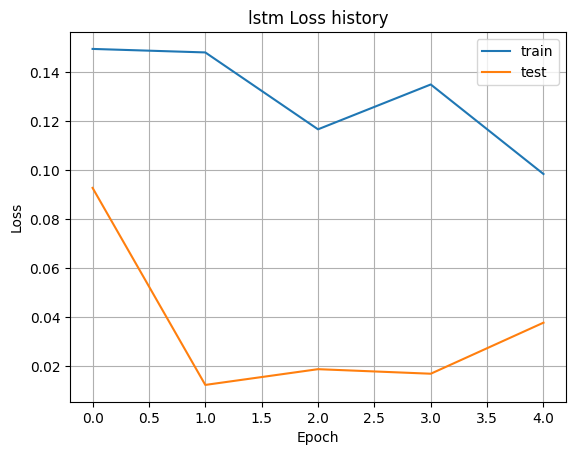

In [52]:
plt.title('lstm Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()

In [59]:
gru_init = GRUFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [60]:
print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (gru): GRU(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 267541


In [61]:
gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs): 
    gru_init.train() 
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    gru_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
            
print('Training is finished!')

Epoch [1/5]. Step [47/47]. Loss: 0.293. Acc: 0.628. Test loss: 0.203. Test acc: 0.930
Epoch [2/5]. Step [47/47]. Loss: 0.223. Acc: 0.930. Test loss: 0.427. Test acc: 0.931
Epoch [3/5]. Step [47/47]. Loss: 0.224. Acc: 0.932. Test loss: 0.563. Test acc: 0.937
Epoch [4/5]. Step [47/47]. Loss: 0.181. Acc: 0.939. Test loss: 0.899. Test acc: 0.944
Epoch [5/5]. Step [47/47]. Loss: 0.192. Acc: 0.947. Test loss: 0.038. Test acc: 0.944
Training is finished!


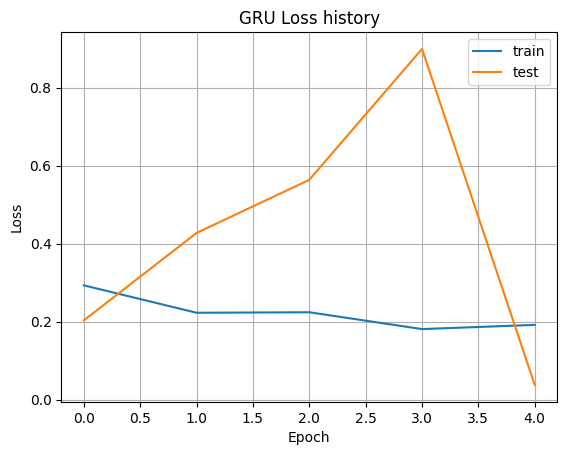

In [62]:
plt.title('GRU Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()